
=== Start 1: [3.0, 1.0] ===


/home/giung/miniconda3/envs/py39/lib/python3.9/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:654.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


1/2500 iteration: 135.655537
500/2500 iteration: 6.332391
1000/2500 iteration: 2.542868
1500/2500 iteration: 1.696065
2000/2500 iteration: 1.366120
2500/2500 iteration: 1.199328


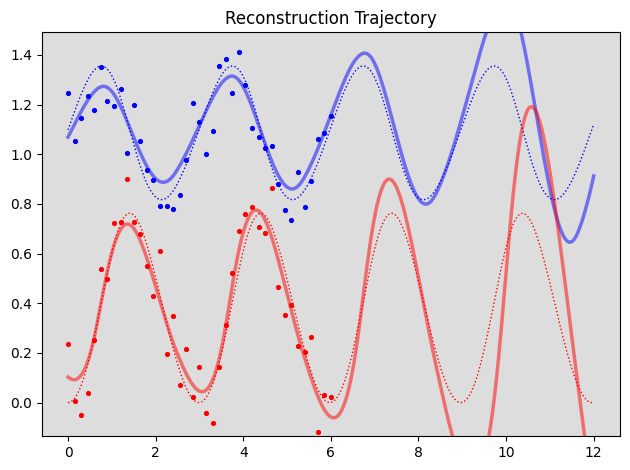


=== Start 2: [4.0, 0.5] ===
1/2500 iteration: 91.509750
500/2500 iteration: 4.640803
1000/2500 iteration: 1.810462
1500/2500 iteration: 1.318825
2000/2500 iteration: 1.172510
2500/2500 iteration: 1.109731


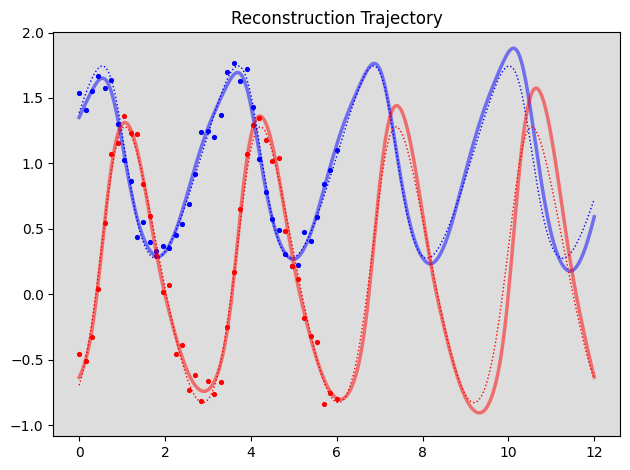


=== Start 3: [5.0, 0.2] ===
1/2500 iteration: 97.889124
500/2500 iteration: 5.176505
1000/2500 iteration: 2.104822
1500/2500 iteration: 1.622874
2000/2500 iteration: 1.462095
2500/2500 iteration: 1.390390


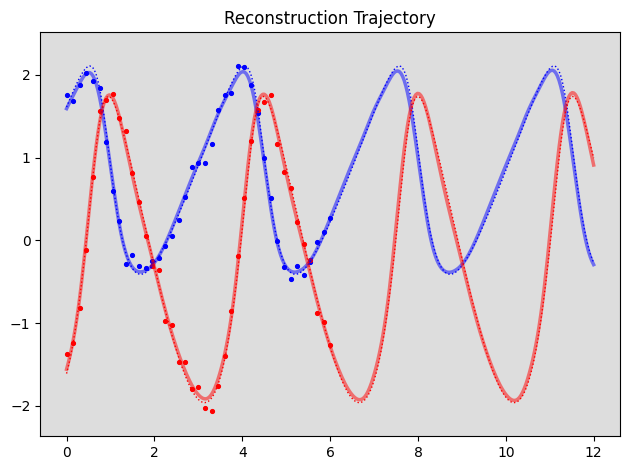


=== Start 4: [7.0, 0.1] ===
1/2500 iteration: 47.600846
500/2500 iteration: 3.318076
1000/2500 iteration: 1.726994
1500/2500 iteration: 1.546336
2000/2500 iteration: 1.495662
2500/2500 iteration: 1.471106


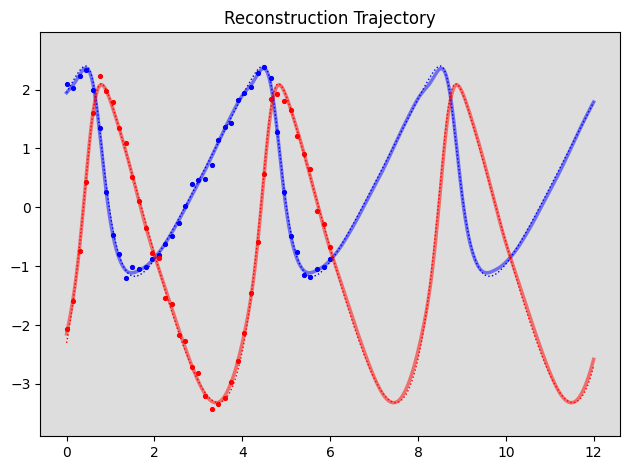

In [1]:
import os, gc, time
import numpy as np
import torch
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scripts.magix.dynamic import nnMTModule
from scripts.magix.inference import FMAGI

# ───────────────────────────────────────────────────
# 0) Settings (match CODE2)
# ───────────────────────────────────────────────────
torch.set_default_dtype(torch.double)
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
torch.set_num_threads(1)

SEED       = 188714368
NOISE      = [0.1, 0.1]
NO_TRAIN   = 41
GRID_SIZE  = 161
MAX_EPOCH  = 2500
LR         = 1e-3
DP         = 0.0

tdata      = np.linspace(0, 12, 321)
obs_idx    = np.linspace(0, int((tdata.size-1)/2), NO_TRAIN).astype(int)
LV_PARAMS  = (1.5, 1.0, 1.0, 3.0)

# colors like CODE2
col = ['b','r','g']

# ───────────────────────────────────────────────────
# 1) Ground-truth LV in (P,D)-space
# ───────────────────────────────────────────────────
def LV(y, t, a, b, c, d):
    P, D = y
    return [a*P - b*P*D, c*P*D - d*D]

# ───────────────────────────────────────────────────
# 2) Build noisy, subsampled log-space observations (match CODE2)
# ───────────────────────────────────────────────────
def build_logspace_obs_from_traj(traj_log, tdata, noise, obs_idx, seed):
    np.random.seed(seed)
    obs = []
    for d in range(traj_log.shape[1]):
        tobs   = tdata[obs_idx].copy()
        y_true = traj_log[obs_idx, d].copy()
        y_noisy= y_true + np.random.normal(0, noise[d], size=len(obs_idx))
        obs.append(np.column_stack([tobs, y_noisy]))
    return obs

# ───────────────────────────────────────────────────
# 3) Train (returnX=True so we can use xinfer[0,:] like CODE2)
# ───────────────────────────────────────────────────
def train_one(traj_log, verbose=True):
    ys = build_logspace_obs_from_traj(traj_log, tdata, NOISE, obs_idx, SEED)
    fOde = nnMTModule(2, [512], dp=DP)
    torch.manual_seed(SEED)
    model = FMAGI(ys, fOde, grid_size=GRID_SIZE, interpolation_orders=3)

    # MAP with same hyperparams as CODE2
    tinfer, xinfer = model.map(
        max_epoch=MAX_EPOCH,
        learning_rate=LR, decay_learning_rate=True,
        hyperparams_update=False,
        dynamic_standardization=True,
        verbose=verbose, returnX=True
    )
    return model, ys, xinfer

# ───────────────────────────────────────────────────
# 4) Four starts → four separate CODE2-style plots
# ───────────────────────────────────────────────────
if __name__ == "__main__":
    starts = [
        [3.0, 1.0],
        [4.0, 0.5],
        [5.0, 0.2],   # CODE2’s default start lives here
        [7.0, 0.1],
    ]

    # make true trajectories in original space, then log-transform
    all_trajs_log = []
    for y0 in starts:
        traj = odeint(LV, y0, tdata, args=LV_PARAMS)   # (T,2) in linear space
        all_trajs_log.append(np.log(traj))             # log-space ground truth
    all_trajs_log = np.array(all_trajs_log)

    # train + plot one figure per start, styled like CODE2
    for k, (start, true_log) in enumerate(zip(starts, all_trajs_log), start=1):
        print(f"\n=== Start {k}: {start} ===")
        model, obs, xinfer = train_one(true_log, verbose=True)

        # reconstruction with ode numerical integration (match CODE2)
        trecon = tdata[np.linspace(0, tdata.size-1, 321).astype(int)]
        x0     = xinfer[0, :].squeeze()   # inferred initial state (log-space)
        tr, xr = model.predict(trecon[1:], trecon[:1], x0, random=False)

        # true "xdata" for this panel is the log-space ground truth
        xdata = true_log
        no_comp = xdata.shape[1]

        # visualization (single-axes figure per start, like CODE2)
        fig = plt.figure(facecolor='w')
        ax  = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
        for i in range(no_comp):
            ax.plot(tr, xr[:, i],            color=col[i], alpha=0.5, lw=2.5)
            ax.plot(tdata, xdata[:, i],      linestyle=':', color=col[i], alpha=1, lw=1)
            ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_ylim(np.min(xdata)-0.1*np.ptp(xdata), np.max(xdata)+0.1*np.ptp(xdata))
        plt.title('Reconstruction Trajectory')
        plt.tight_layout()
        plt.show()

        # clean up before next start (helps runtime stability)
        del model
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
            torch.cuda.empty_cache()



=== Start 1: [3.0, 1.0] ===
1/2500 iteration: 135.895319
500/2500 iteration: 6.382686
1000/2500 iteration: 2.563476
1500/2500 iteration: 1.707259
2000/2500 iteration: 1.365396
2500/2500 iteration: 1.195097

=== Start 2: [4.0, 0.5] ===
1/2500 iteration: 91.509750
500/2500 iteration: 4.640803
1000/2500 iteration: 1.810462
1500/2500 iteration: 1.318825
2000/2500 iteration: 1.172510
2500/2500 iteration: 1.109731

=== Start 3: [5.0, 0.2] ===
1/2500 iteration: 97.889124
500/2500 iteration: 5.176505
1000/2500 iteration: 2.104822
1500/2500 iteration: 1.622874
2000/2500 iteration: 1.462095
2500/2500 iteration: 1.390390

=== Start 4: [7.0, 0.1] ===
1/2500 iteration: 47.600846
500/2500 iteration: 3.318076
1000/2500 iteration: 1.726994
1500/2500 iteration: 1.546336
2000/2500 iteration: 1.495662
2500/2500 iteration: 1.471106


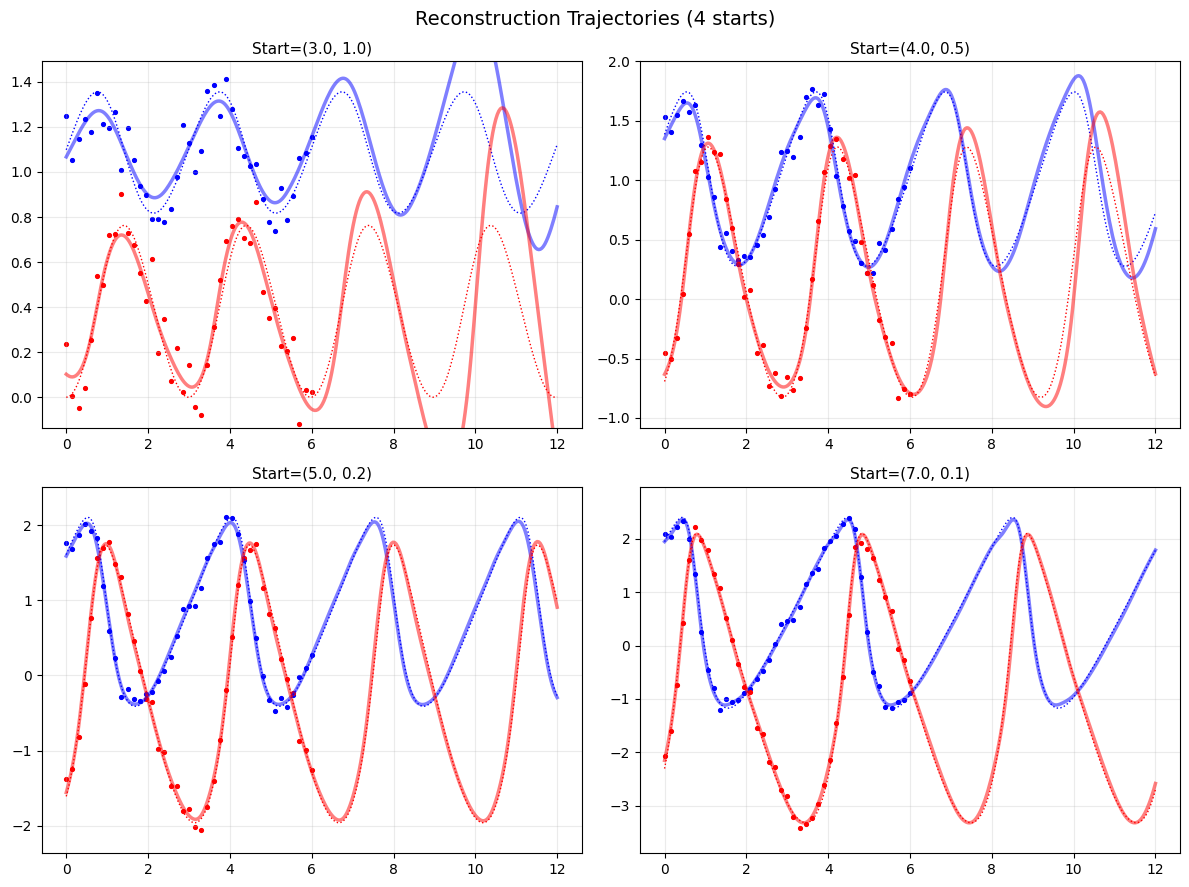

In [2]:
# ───────────────────────────────────────────────────
# 4) Train all, then show four plots together (2×2 grid)
# ───────────────────────────────────────────────────
if __name__ == "__main__":
    starts = [
        [3.0, 1.0],
        [4.0, 0.5],
        [5.0, 0.2],   # CODE2’s default start
        [7.0, 0.1],
    ]

    # make true trajectories in original space, then log-transform
    all_trajs_log = []
    for y0 in starts:
        traj = odeint(LV, y0, tdata, args=LV_PARAMS)   # (T,2) in linear space
        all_trajs_log.append(np.log(traj))             # log-space ground truth
    all_trajs_log = np.array(all_trajs_log)

    # Train all starts and store artifacts for plotting later
    results = []
    for k, (start, true_log) in enumerate(zip(starts, all_trajs_log), start=1):
        print(f"\n=== Start {k}: {start} ===")
        model, obs, xinfer = train_one(true_log, verbose=True)

        # reconstruction with ODE numerical integration (match CODE2)
        trecon = tdata[np.linspace(0, tdata.size-1, 321).astype(int)]
        x0     = xinfer[0, :].squeeze()   # inferred initial state (log-space)
        tr, xr = model.predict(trecon[1:], trecon[:1], x0, random=False)

        results.append({
            "start": start,
            "true_log": true_log,  # xdata-style ground truth (log-space)
            "obs": obs,
            "tr": tr,
            "xr": xr,
        })

        # cleanup between trainings (keeps runtime stable)
        del model
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
            torch.cuda.empty_cache()

    # ── Single figure with 4 panels (like CODE2 style per panel) ──
    fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex=False, sharey=False)
    axes = axes.flatten()

    for ax, res in zip(axes, results):
        start   = res["start"]
        xdata   = res["true_log"]
        obs     = res["obs"]
        tr, xr  = res["tr"], res["xr"]

        no_comp = xdata.shape[1]
        for i in range(no_comp):
            ax.plot(tr, xr[:, i],               color=col[i], alpha=0.5, lw=2.5)
            ax.plot(tdata, xdata[:, i],         linestyle=':', color=col[i], alpha=1, lw=1)
            ax.scatter(obs[i][:,0], obs[i][:,1], s=7.5, marker='o', color=col[i])

        # axis cosmetics like CODE2
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_ylim(np.min(xdata) - 0.1*np.ptp(xdata),
                    np.max(xdata) + 0.1*np.ptp(xdata))
        ax.set_title(f'Start=({start[0]:.1f}, {start[1]:.1f})', fontsize=11)
        ax.grid(True, alpha=0.25)

    # if fewer than 4 results (just in case), hide extra axes
    for ax in axes[len(results):]:
        ax.axis('off')

    fig.suptitle('Reconstruction Trajectories (4 starts)', fontsize=14, y=0.98)
    plt.tight_layout()
    plt.show()
